<a href="https://colab.research.google.com/github/YonggunJung/colab/blob/main/1108DLotto%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
win = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/로또/data/jlotto.csv', delimiter = ',')
win

array([[ 4.,  7., 17., 18., 38., 44.],
       [ 8., 12., 13., 29., 33., 42.],
       [ 3.,  7., 14., 15., 22., 38.],
       ...,
       [ 6., 16., 34., 37., 39., 40.],
       [ 1.,  3.,  4., 29., 42., 45.],
       [ 6., 14., 30., 31., 40., 41.]])

In [4]:
xn = len(win)

In [5]:
# 숫자를 원핫 인코딩으로 변환
def n2o(numbers):

  oh = np.zeros(45)  # 45개의 빈 칸 만들기

  for i in range(6):            # 6개의 당첨번호를 반복
      oh[int(numbers[i])-1] = 1   # 번호는 1부터 시작하고 인덱스는 0부터 시작하니 1을 빼줌

  return oh

# 원핫 인코딩을 숫자로 변환
def o2n(oh):

  numbers = []

  for i in range(len(oh)):
    if oh[i] == 1:           # oh[i]이 1 이면 해당 번호를 출력
      numbers.append(i+1)    # 인덱스 보다 숫자가 1크니까 1더해줌 출력

  return numbers

In [6]:
numbers = win[: , :]  # 이게 문제라서 못 하겠음ㅠ 데이터 프레임이 문제인가?
                      # 데이터 프레임으로 안열고 넘파이 텍스트 파일로 가져오니 됨
ohs = list(map(n2o, numbers))

xs = ohs[0:xn -1]
ys = ohs[1:xn]

# 원핫 인코딩 확인
print('ohs')
print('x[0] :' + str(xs[0]))
print('y[0] :' + str(ys[0]))

# 번호 확인
print('numbers')
print('x[0] :' + str(o2n(xs[0])))
print('y[0] :' + str(o2n(ys[0])))

ohs
x[0] :[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
y[0] :[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
x[0] :[4, 7, 17, 18, 38, 44]
y[0] :[8, 12, 13, 29, 33, 42]


In [7]:
train = (0, int(len(win)*0.6))
val = (int(len(win)*0.6), int(len(win)*0.8))
test = (int(len(win)*0.8), len(win))

print('train : {0}, val : {1}, test : {2}'.format(train, val, test))

train : (0, 664), val : (664, 885), test : (885, 1107)


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델 정의
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape = (1, 1, 45),
                      return_sequences = False,
                      stateful = True),
    keras.layers.Dense(45, activation = 'sigmoid')
])

# 모델 컴파일
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [9]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(51):
    model.reset_states()  # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []

    for i in range(train[0], train[1]):

        xss = xs[i].reshape(1, 1, 45)
        yss = ys[i].reshape(1, 45)

        loss, acc = model.train_on_batch(xss, yss) # 배치만큼 모델에 학습

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val[0], val[1]):

        xss = xs[i].reshape(1, 1, 45)
        yss = ys[i].reshape(1, 45)

        loss, acc = model.test_on_batch(xss, yss) # 배치만큼 모델에 입력하여 나온 결과를 정답과 비교함

        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch{0:4d}, acc {1:0.3f}, loss {2: 0.3f}, val_acc {3:0.3f}, val_loss {4:0.3f}'.format(epoch,
                                                                                                  np.mean(batch_train_acc),
                                                                                                  np.mean(batch_train_loss),
                                                                                                  np.mean(batch_val_acc),
                                                                                                  np.mean(batch_val_loss)))

epoch   0, acc 0.014, loss  0.410, val_acc 0.000, val_loss 0.400
epoch   1, acc 0.017, loss  0.396, val_acc 0.000, val_loss 0.399
epoch   2, acc 0.020, loss  0.394, val_acc 0.005, val_loss 0.400
epoch   3, acc 0.029, loss  0.391, val_acc 0.009, val_loss 0.400
epoch   4, acc 0.036, loss  0.387, val_acc 0.014, val_loss 0.401
epoch   5, acc 0.048, loss  0.382, val_acc 0.023, val_loss 0.405
epoch   6, acc 0.048, loss  0.376, val_acc 0.027, val_loss 0.410
epoch   7, acc 0.063, loss  0.370, val_acc 0.032, val_loss 0.414
epoch   8, acc 0.063, loss  0.364, val_acc 0.032, val_loss 0.418
epoch   9, acc 0.062, loss  0.358, val_acc 0.032, val_loss 0.422
epoch  10, acc 0.069, loss  0.351, val_acc 0.036, val_loss 0.427
epoch  11, acc 0.071, loss  0.344, val_acc 0.032, val_loss 0.432
epoch  12, acc 0.081, loss  0.337, val_acc 0.032, val_loss 0.438
epoch  13, acc 0.095, loss  0.329, val_acc 0.032, val_loss 0.443
epoch  14, acc 0.114, loss  0.320, val_acc 0.032, val_loss 0.449
epoch  15, acc 0.123, los

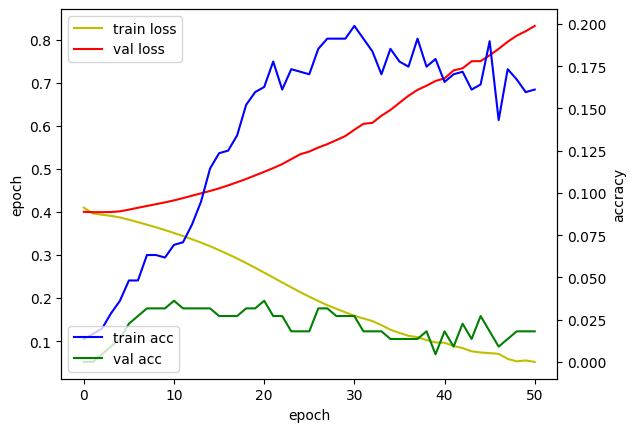

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label = 'train loss')
loss_ax.plot(val_loss, 'r', label = 'val loss')

acc_ax.plot(train_acc, 'b', label = 'train acc')
acc_ax.plot(val_acc, 'g', label = 'val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('epoch')
acc_ax.set_ylabel('accracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()
# 이미 학습은 의미가 없다는 결론이 나옴

In [11]:
# 모든 데이터를 학습용으로 사용
for epoch in range(51):

    model.reset_states()  # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(xs)):

      xss = xs[i].reshape(1, 1, 45)
      yss - ys[i].reshape(1, 45)

      loss, acc = model.train_on_batch(xss, yss) # 배치만큼 모델에 학습

      batch_train_loss.append(loss)
      batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch{0:4d}, acc {1:0.3f}, loss {2: 0.3f}'.format(epoch,
                                                            np.mean(batch_train_acc),
                                                            np.mean(batch_train_loss)
                                                            ))



epoch   0, acc 0.176, loss  0.030
epoch   1, acc 0.158, loss  0.019
epoch   2, acc 0.146, loss  0.014
epoch   3, acc 0.134, loss  0.011
epoch   4, acc 0.125, loss  0.009
epoch   5, acc 0.120, loss  0.007
epoch   6, acc 0.116, loss  0.006
epoch   7, acc 0.115, loss  0.006
epoch   8, acc 0.115, loss  0.005
epoch   9, acc 0.117, loss  0.005
epoch  10, acc 0.120, loss  0.004
epoch  11, acc 0.124, loss  0.004
epoch  12, acc 0.130, loss  0.004
epoch  13, acc 0.135, loss  0.003
epoch  14, acc 0.141, loss  0.003
epoch  15, acc 0.145, loss  0.003
epoch  16, acc 0.148, loss  0.003
epoch  17, acc 0.150, loss  0.003
epoch  18, acc 0.151, loss  0.002
epoch  19, acc 0.152, loss  0.002
epoch  20, acc 0.153, loss  0.002
epoch  21, acc 0.153, loss  0.002
epoch  22, acc 0.153, loss  0.002
epoch  23, acc 0.153, loss  0.002
epoch  24, acc 0.152, loss  0.002
epoch  25, acc 0.152, loss  0.002
epoch  26, acc 0.151, loss  0.002
epoch  27, acc 0.150, loss  0.002
epoch  28, acc 0.150, loss  0.002
epoch  29, acc

In [12]:
# 다음회 예측

print('receive numbers')

xss = xs[-1].reshape(1, 1, 45)

pred = model.predict_on_batch(xss)
pred

luck = list(map(o2n, pred))
luck

# list_number = []

# for n in range(6):
#   numbers =pred
  # numbers.sort()
  # print('{0} : {1}'.format(n, numbers))
  # list_numbers.append(numbers)

receive numbers


[[5, 6, 13, 14, 17, 20]]